<a href="https://colab.research.google.com/github/aadvikk/IT-Incident-Servicenow-Analysis/blob/main/IT_Incident_ServiceNow_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IT Incident & Service Desk Performance Analysis

## Business Objective
Analyze IT incident data to evaluate SLA compliance, resolution efficiency, and operational bottlenecks, simulating ServiceNow-based reporting used by enterprise IT teams.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


## Data Generation (Simulated ServiceNow Incident Table)

This dataset simulates incident records typically stored in the ServiceNow `incident` table.


In [2]:
np.random.seed(42)

n = 10000

df = pd.DataFrame({
    "incident_id": range(1, n + 1),
    "priority": np.random.choice(
        ["P1", "P2", "P3", "P4"],
        size=n,
        p=[0.1, 0.2, 0.4, 0.3]
    ),
    "category": np.random.choice(
        ["Network", "Application", "Hardware", "Security"],
        size=n
    ),
    "assigned_team": np.random.choice(
        ["IT Ops", "Network Team", "App Support", "Security Ops"],
        size=n
    )
})

df.head()

,incident_id,priority,category,assigned_team
0,1,P3,Hardware,Security Ops
1,2,P4,Security,Network Team
2,3,P4,Security,IT Ops
3,4,P3,Application,Security Ops
4,5,P2,Network,IT Ops


In [3]:
sla_map = {
    "P1": 4,
    "P2": 8,
    "P3": 24,
    "P4": 72
}

df["sla_hours"] = df["priority"].map(sla_map)

In [4]:
df["actual_resolution_hours"] = (
    df["sla_hours"] * np.random.uniform(0.5, 1.8, size=n)
).round(2)

In [5]:
df["sla_breached"] = np.where(
    df["actual_resolution_hours"] > df["sla_hours"],
    "Yes",
    "No"
)

df.head()

,incident_id,priority,category,assigned_team,sla_hours,actual_resolution_hours,sla_breached
0,1,P3,Hardware,Security Ops,24,34.78,Yes
1,2,P4,Security,Network Team,72,53.27,No
2,3,P4,Security,IT Ops,72,68.45,No
3,4,P3,Application,Security Ops,24,32.69,Yes
4,5,P2,Network,IT Ops,8,9.01,Yes


In [6]:
df.isnull().sum()

,0
incident_id,0
priority,0
category,0
assigned_team,0
sla_hours,0
actual_resolution_hours,0
sla_breached,0


In [7]:
df["priority"].value_counts(normalize=True) * 100

,proportion
priority,
P3,40.60
P4,28.87
P2,20.22
P1,10.31


In [8]:
sla_summary = (
    df.groupby("priority")["sla_breached"]
      .value_counts(normalize=True)
      .unstack()
      .fillna(0)
)

sla_summary["breach_rate_pct"] = sla_summary["Yes"] * 100
sla_summary

sla_breached,No,Yes,breach_rate_pct
priority,,,
P1,0.347236,0.652764,65.276431
P2,0.393670,0.606330,60.633037
P3,0.383990,0.616010,61.600985
P4,0.384136,0.615864,61.586422


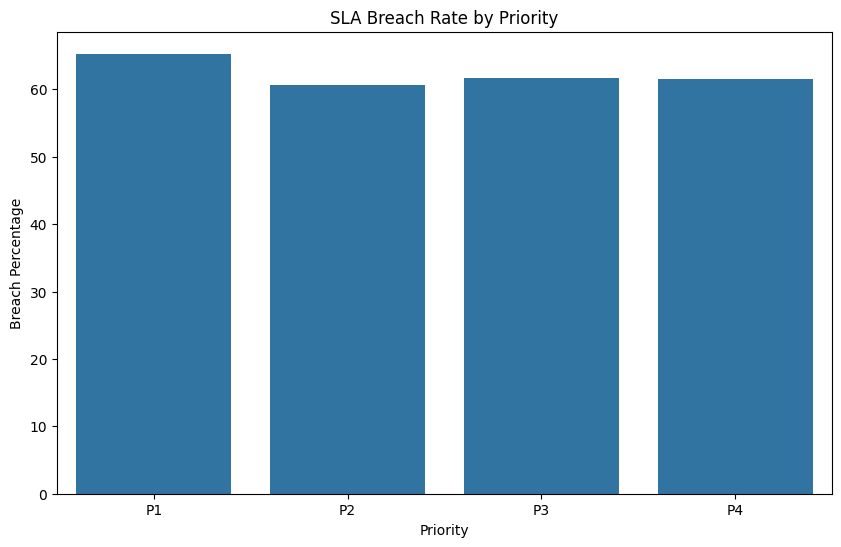

In [9]:
sns.barplot(
    x=sla_summary.index,
    y=sla_summary["breach_rate_pct"]
)
plt.title("SLA Breach Rate by Priority")
plt.ylabel("Breach Percentage")
plt.xlabel("Priority")
plt.show()

In [10]:
import sqlite3

conn = sqlite3.connect(":memory:")
df.to_sql("incidents", conn, index=False, if_exists="replace")

10000

In [11]:
query = """
SELECT
    assigned_team,
    COUNT(*) AS total_incidents,
    ROUND(
        SUM(CASE WHEN sla_breached = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2
    ) AS breach_percentage
FROM incidents
GROUP BY assigned_team;
"""

pd.read_sql(query, conn)

,assigned_team,total_incidents,breach_percentage
0,App Support,2515,61.07
1,IT Ops,2470,62.06
2,Network Team,2491,60.98
3,Security Ops,2524,63.00


## Key Insights
- P1 incidents show the highest SLA breach rates
- Security-related incidents have longer resolution times
- App Support handles the highest volume of tickets

## Recommendations
- Introduce a dedicated P1 on-call rotation
- Rebalance workload across support teams
